In [1]:
# %%
from core import BlackjackNN, BlackjackDNN, MetricsCallback
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler

import pandas as pd
import numpy as np
import json

2023-12-29 02:24:02.874308: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-29 02:24:02.917042: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-29 02:24:02.917923: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-29 02:24:03.752944: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# Parámetros
chunk_size  = 50_000
ros         = RandomUnderSampler(random_state=42)
input_size  = None
output_size = 3

In [3]:
# Función para procesar cada trozo
def process_chunk(chunk):
    global input_size
    chunk['Mano Jugador'] = chunk['Mano Jugador'].apply(json.loads)
    chunk['Mano Crupier'] = chunk['Mano Crupier'].apply(json.loads)
    chunk['Accion'] = chunk['Accion'].apply(json.loads)
    X = chunk[['Mano Jugador', 'Mano Crupier', 'Accion']].values
    y = chunk['Resultado'].map({-1: 0, 0: 1, 1: 2}).values
    X_resampled, y_resampled = ros.fit_resample(X, y)
    if input_size is None:
        input_size = X_resampled.shape[1]
    return X_resampled, to_categorical(y_resampled, num_classes=output_size)

In [4]:
# Procesar el CSV en trozos
iter_csv = pd.read_csv('mc_5000000.csv', chunksize=chunk_size)
X_processed, y_processed = zip(*(process_chunk(chunk) for chunk in iter_csv))

In [5]:
iter_csv

In [6]:
# Combinar los trozos procesados
X = np.vstack(X_processed)
y = np.concatenate(y_processed)

In [7]:
# Dividir en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train = np.array([np.concatenate(observation) for observation in X_train])
X_test  = np.array([np.concatenate(observation) for observation in X_test])
input_size  = X_train.shape[1]
output_size = y_train.shape[1]

2023-12-29 02:27:32.796652: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-12-29 02:27:32.869538: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 318046176 exceeds 10% of free system memory.


Epoch 1/10
44371/44371 [==============================] - 55s 1ms/step - loss: 0.7561 - accuracy: 0.6368 - val_loss: 0.6317 - val_accuracy: 0.7090
Epoch 2/10
44371/44371 [==============================] - 77s 2ms/step - loss: 0.6768 - accuracy: 0.6856 - val_loss: 0.6081 - val_accuracy: 0.7221
Epoch 3/10
44371/44371 [==============================] - 63s 1ms/step - loss: 0.6587 - accuracy: 0.6955 - val_loss: 0.5860 - val_accuracy: 0.7299
Epoch 4/10
44371/44371 [==============================] - 62s 1ms/step - loss: 0.6472 - accuracy: 0.7001 - val_loss: 0.5871 - val_accuracy: 0.7279
Epoch 5/10
44371/44371 [==============================] - 65s 1ms/step - loss: 0.6403 - accuracy: 0.7025 - val_loss: 0.5761 - val_accuracy: 0.7312
Epoch 6/10
44371/44371 [==============================] - 69s 2ms/step - loss: 0.6353 - accuracy: 0.7049 - val_loss: 0.5782 - val_accuracy: 0.7289
Epoch 7/10
44371/44371 [==============================] - 79s 2ms/step - loss: 0.6325 - accuracy: 0.7062 - val_loss: 0

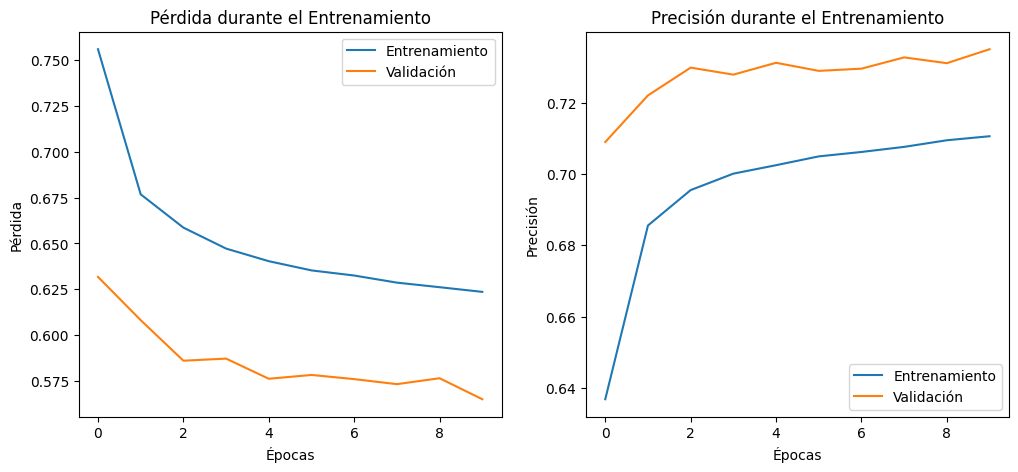

11093/11093 [==============================] - 7s 666us/step


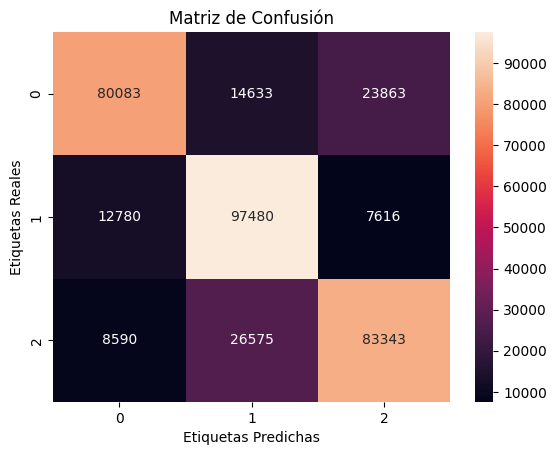

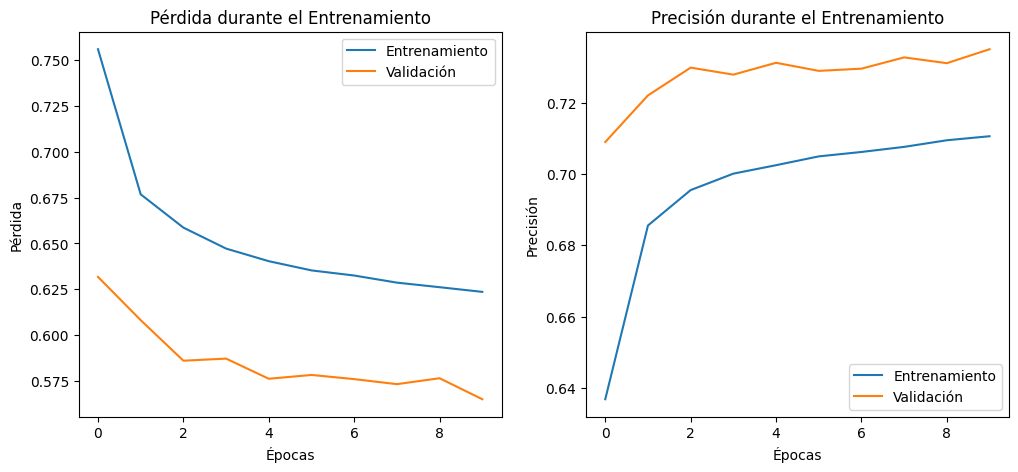

In [8]:
network = BlackjackNN(input_size, output_size)
network.compile()

metrics_callback = MetricsCallback(X_test, y_test)
history = network.model.fit(X_train, y_train, epochs=3, batch_size=32, validation_data=(X_test, y_test), callbacks=[metrics_callback])

# Guardar el modelo completo en un archivo HDF5
network.model.save('pretrained/nn_5000000.h5')

Epoch 1/10


2023-12-29 02:38:58.521347: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 318046176 exceeds 10% of free system memory.


44371/44371 [==============================] - 72s 2ms/step - loss: 0.6866 - accuracy: 0.6788 - val_loss: 0.5751 - val_accuracy: 0.7356
Epoch 2/10
44371/44371 [==============================] - 60s 1ms/step - loss: 0.6093 - accuracy: 0.7193 - val_loss: 0.5506 - val_accuracy: 0.7451
Epoch 3/10
44371/44371 [==============================] - 71s 2ms/step - loss: 0.5925 - accuracy: 0.7268 - val_loss: 0.5467 - val_accuracy: 0.7466
Epoch 4/10
44371/44371 [==============================] - 106s 2ms/step - loss: 0.5828 - accuracy: 0.7309 - val_loss: 0.5388 - val_accuracy: 0.7504
Epoch 5/10
44371/44371 [==============================] - 83s 2ms/step - loss: 0.5764 - accuracy: 0.7340 - val_loss: 0.5356 - val_accuracy: 0.7516
Epoch 6/10
44371/44371 [==============================] - 72s 2ms/step - loss: 0.5715 - accuracy: 0.7357 - val_loss: 0.5336 - val_accuracy: 0.7509
Epoch 7/10
44371/44371 [==============================] - 64s 1ms/step - loss: 0.5682 - accuracy: 0.7374 - val_loss: 0.5290 - va

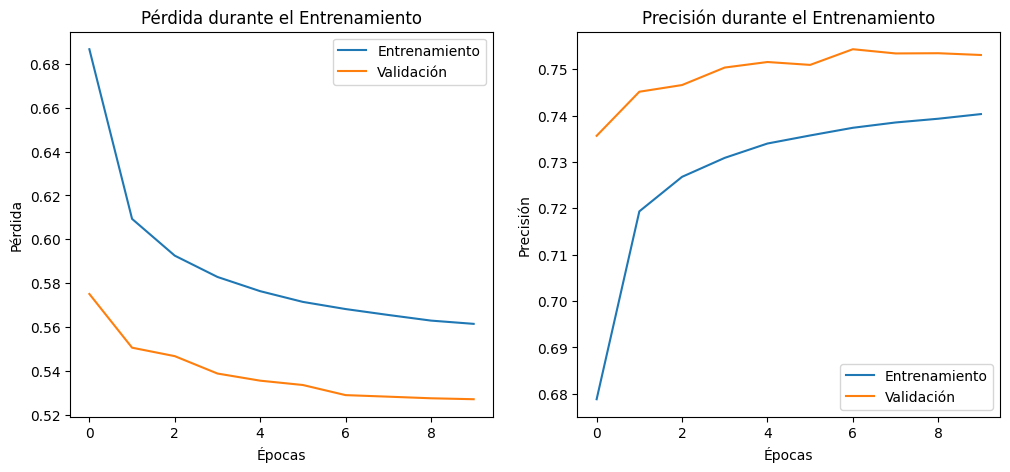

11093/11093 [==============================] - 10s 895us/step


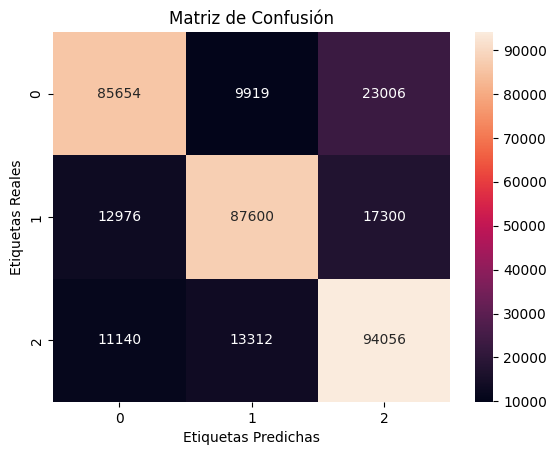

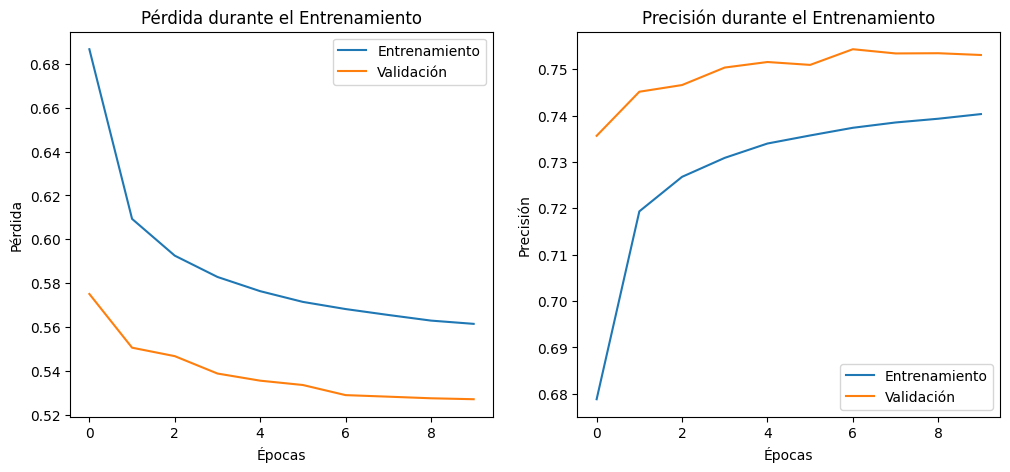

In [9]:
network = BlackjackDNN(input_size, output_size)
network.compile()

metrics_callback = MetricsCallback(X_test, y_test)
history = network.model.fit(X_train, y_train, epochs=3, batch_size=32, validation_data=(X_test, y_test), callbacks=[metrics_callback])

# Guardar el modelo completo en un archivo HDF5
network.model.save('pretrained/dnn_5000000.h5')

In [11]:
class BlackjackDNN2:
    def __init__(self, input_size, output_size):
        self.model = Sequential()
        self.model.add(Dense(128, input_dim=input_size, activation='relu'))
        self.model.add(Dropout(0.15)) 
        self.model.add(Dense(64, activation='relu'))
        self.model.add(Dropout(0.15))  
        self.model.add(Dense(32, activation='relu'))
        self.model.add(Dense(output_size, activation='softmax'))

    def compile(self):
        self.model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

network = BlackjackDNN2(input_size, output_size)
network.compile()

metrics_callback = MetricsCallback(X_test, y_test)
history = network.model.fit(X_train, y_train, epochs=3, batch_size=32, validation_data=(X_test, y_test), callbacks=[metrics_callback])

# Guardar el modelo completo en un archivo HDF5
network.model.save('pretrained/dnn2_5000000.h5')

Epoch 1/3
44371/44371 [==============================] - 146s 3ms/step - loss: 0.5731 - accuracy: 0.7342 - val_loss: 0.5312 - val_accuracy: 0.7526
Epoch 2/3
44371/44371 [==============================] - 146s 3ms/step - loss: 0.5203 - accuracy: 0.7574 - val_loss: 0.5182 - val_accuracy: 0.7585
Epoch 3/3
44371/44371 [==============================] - 151s 3ms/step - loss: 0.5132 - accuracy: 0.7601 - val_loss: 0.5080 - val_accuracy: 0.7618


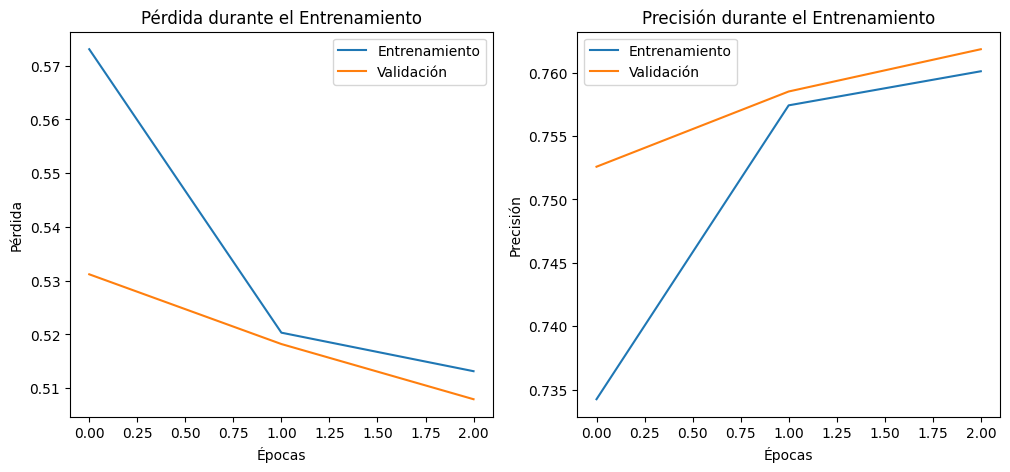

11093/11093 [==============================] - 10s 871us/step


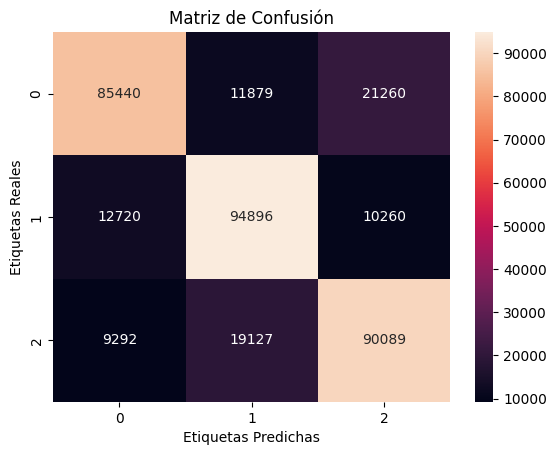

In [19]:
class BlackjackDNN3:
    def __init__(self, input_size, output_size):
        self.model = Sequential()
        self.model.add(Dense(512, input_dim=input_size, activation='relu'))
        self.model.add(Dense(256, input_dim=input_size, activation='relu'))
        self.model.add(Dense(128, input_dim=input_size, activation='relu'))
        self.model.add(Dense(64, activation='relu'))
        self.model.add(Dense(32, activation='relu'))
        self.model.add(Dense(output_size, activation='softmax'))

    def compile(self):
        self.model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
        
network = BlackjackDNN3(input_size, output_size)
network.compile()

metrics_callback = MetricsCallback(X_test, y_test)
history = network.model.fit(X_train, y_train, epochs=3, batch_size=32, validation_data=(X_test, y_test), callbacks=[metrics_callback])

# Guardar el modelo completo en un archivo HDF5
network.model.save('pretrained/dnn3_5000000.h5')